In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Modelo de Potts

In [2]:
class PottsModel:
#Clase del modelo, dá las condiciones iniciales de la grilla, inicializa los spines.
    def __init__(self, L, q, T, J=1.0):
        self.L = L #dimensión de la grilla en m
        self.q = q #Cantidad de estados
        self.T = T #Temperatura J/k_b
        self.J = J #Constante de acoplamiento J
        self.spins = None
        self.initialize_spins()

#----------------------Metodo para inicializar el spin---------------------------

    def initialize_spins(self):
        # Inicializar spines aleatoriamente
        self.spins = np.random.randint(0, self.q, (self.L, self.L))

#--------------------------------------------------------------------------------


#--------------------Método para calcular la energía de forma local-------------

    def local_energy(self, i, j, new_state):
        L = self.L
        old_state = self.spins[i, j]

        #vecinos

        vecinos = [
            self.spins[(i+1)%L, j],
            self.spins[(i-1)%L, j],
            self.spins[i, (j+1)%L],
            self.spins[i, (j-1)%L]
            ]
        #vecinos con estado viejo
        match_old = sum(1 for s in vecinos if s == old_state)

        #vecinos con estado nuevo propuesto
        match_new = sum(1 for s in vecinos if s == new_state)

        return 2.0*-self.J * (match_new - match_old)

#-------------------------------------------------------------------------------


#------------------Método para calcular la energía total del sistema------------


    def total_energy(self):
    # Energía total del sistema
        energy = 0
        for i in range(self.L):
            for j in range(self.L):
                #Enlace horizontal
                if self.spins[i, j] == self.spins[i, (j+1) % self.L]:
                    energy -= self.J

                # Enlace VERTICAL:
                if self.spins[i, j] == self.spins[(i+1) % self.L, j]:
                    energy -= self.J

        return energy


#---------------------------------------------------------------------------------------

#------------------------Cálcular el parámetro de orden---------------------------------

    def magnetization(self):
    # Caso trivial
      if self.q == 1:
            return 1.0

    # Caso Ising
      elif self.q == 2:
        # ISING: con signo
        spins_ising = 2 * self.spins.astype(float) - 1
        return np.mean(spins_ising)

      else:
        # POTTS: parámetro de orden (sin signo)
        counts = np.bincount(self.spins.flatten(), minlength=self.q)
        max_fraction = np.max(counts) / self.spins.size
        return (max_fraction - 1/self.q) / (1 - 1/self.q)

#------------------------------------------------------------------------------------


In [3]:
class MonteCarlo:
    def __init__(self, model):
        self.model = model
        self.energy_history = []
        self.mag_history = []

#---------------Algoritmo de metrópolis-------------------------

    def metropolis_step(self):
        # Un paso del algoritmo de Metropolis
        L = self.model.L
        q = self.model.q
        i, j = np.random.randint(0, L, 2)
        old_state = self.model.spins[i, j]

        if q > 1:
          possible_states = list(range(q))
          possible_states.remove(old_state)
          new_state = np.random.choice(possible_states)
        else:
          new_state = old_state
        # Calcula el cambio de energía
        dE = self.model.local_energy(i, j, new_state)

        #Criterio de Metrópolis para aceptar/rechazar nuevos estados
        if dE < 0:
          self.model.spins[i, j] = new_state

        else:
          prob = np.exp(-dE/self.model.T)
          if np.random.rand() < prob:
            self.model.spins[i, j] = new_state

#------------------------------------------------------------

#---------------------- Evolución del sistema ---------------

    def run(self, steps, thermalization):
        # Ejecutar simulación
        for step in range(steps + thermalization):
            for _ in range(self.model.L * self.model.L):
                self.metropolis_step()
            #Steps de termalización para que la simulación se estabilize.
            #Las cantidades físicas se calculan con los steps que siguen despues de termalización
            if step >= thermalization:
                E = self.model.total_energy()
                self.energy_history.append(E)
                self.mag_history.append(self.model.magnetization())

#------------------------------------------------------------


# Análisis de datos y pruebas

In [4]:
class Analysis:
    # Clase para calcular las cantidades termodinámicas de importancia
    def __init__(self, mc_data):
        self.mc = mc_data
        self.energy = mc_data.energy_history
        self.magnetization = mc_data.mag_history

    def specific_heat(self):
        # Calor específico
        E = np.array(self.energy)

        return (np.var(E) / ((self.mc.model.L**2) *self.mc.model.T**2))

    def susceptibility(self):
        #Susceptibilidad magnética
        M = np.array(self.magnetization)
        return (np.var(M)*self.mc.model.L**2 /(self.mc.model.T))

In [ ]:
#--------------------rutina para observar la magnetización correspondiente a cada temperatura-----------------------------#

# Rango de temperaturas
temperaturas = np.linspace(0.1, 4.0, 15)   # 10 puntos entre 0.5 y 3.5
magnetizaciones = []

L = 20      # tamaño de la red
q = 8       # Ising
steps = 3000
thermal = 3000

for T in temperaturas:
    Potts = PottsModel(L=L, q=q, T=T)
    mc = MonteCarlo(Potts)

    mc.run(steps=steps, thermalization=thermal)

    # Magnetización promedio después de termalizar
    m_prom = np.mean(mc.mag_history)
    magnetizaciones.append(m_prom)

    print(f"T = {T:.2f}  ->  <m> = {m_prom:.4f}")


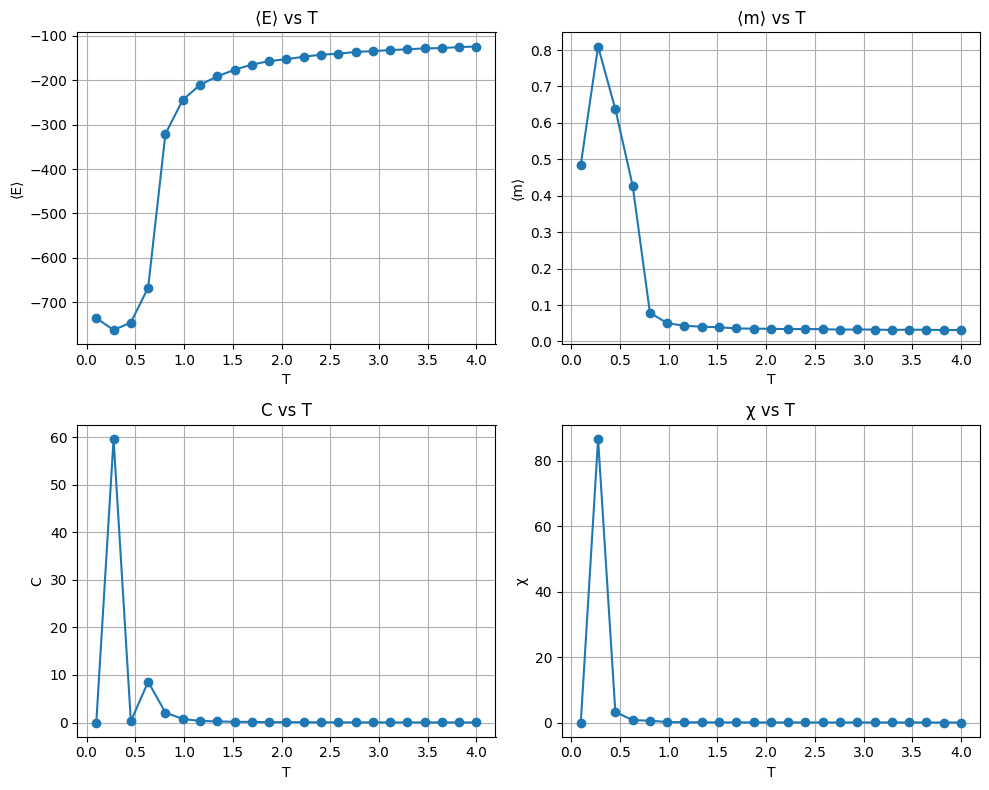

In [ ]:

#------------------------------Rutina para gráficar las cantidades térmodinamicas contra la temperatura-------------------------------------
temperaturas = np.linspace(0.1, 4.0, 23)
resultados = []

for T in temperaturas:
    # Crear nuevo modelo
    Potts = PottsModel(L=20, q=8, T=T)
    mc_data = MonteCarlo(Potts)
    mc_data.run(steps=1000, thermalization=500)

    results = Analysis(mc_data)
    resultados.append({
        'T': T,
        'C': results.specific_heat(),
        'χ': results.susceptibility(),
        '⟨E⟩': np.mean(results.energy),
        '⟨m⟩': np.mean(results.magnetization)
    })

# Graficar
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

T_vals = [r['T'] for r in resultados]

axes[0,0].plot(T_vals, [r['⟨E⟩'] for r in resultados], 'o-')
axes[0,0].set_xlabel('T')
axes[0,0].set_ylabel('⟨E⟩')
axes[0,0].set_title('⟨E⟩ vs T')
axes[0,0].grid(True)

axes[0,1].plot(T_vals, [r['⟨m⟩'] for r in resultados], 'o-')
axes[0,1].set_xlabel('T')
axes[0,1].set_ylabel('⟨m⟩')
axes[0,1].set_title('⟨m⟩ vs T')
axes[0,1].grid(True)

axes[1,0].plot(T_vals, [r['C'] for r in resultados], 'o-')
axes[1,0].set_xlabel('T')
axes[1,0].set_ylabel('C')
axes[1,0].set_title('C vs T')
axes[1,0].grid(True)

axes[1,1].plot(T_vals, [r['χ'] for r in resultados], 'o-')
axes[1,1].set_xlabel('T')
axes[1,1].set_ylabel('χ')
axes[1,1].set_title('χ vs T')
axes[1,1].grid(True)

plt.tight_layout()
plt.savefig("Comportamiento_Ising")
plt.show()


## Evoluciones del sistema q = 2

In [ ]:
def visualizar_metropolis_potts(T=2.0, L=20, q=2, preTherm=500, nSteps=5000):
   # Función para vizualizar la evolucion temporal del modelo

    # Crear instancia del modelo de Potts
    model = PottsModel(L=L, q=q, T=T)
    mc = MonteCarlo(model)

    # Configuración inicial
    lattice_initial = model.spins.copy()

    # Crear figura con múltiples subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Colormap dependiendo de q
    if q == 2:
        cmap = 'coolwarm'
        vmin, vmax = 0, 1  # Para q=2 (Ising: 0 y 1)
    else:
        cmap = 'viridis'  # Bueno para múltiples estados discretos
        vmin, vmax = 0, q-1

    # Visualizar configuración inicial
    axes[0].imshow(lattice_initial, cmap=cmap, vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Configuración inicial\nT = {T:.2f}, q = {q}',
                     fontsize=12, fontweight='bold')
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Historial de magnetización
    magnetizaciones = []

    # Dividir nSteps en 5 intervalos iguales
    intervalos = nSteps // 5

    # Primero: termalización
    print(f"Termalizando por {preTherm} pasos...")
    for _ in range(preTherm):
        for _ in range(L * L):
            mc.metropolis_step()

    # Segundo: evolución y visualización
    lattice_current = model.spins.copy()

    for idx in range(1, 6):
        # Ejecutar pasos de Monte Carlo
        pasos_ejecutar = intervalos if idx < 5 else nSteps - (intervalos * 4)

        print(f"Ejecutando {pasos_ejecutar} pasos para etapa {idx}/5...")

        for paso in range(pasos_ejecutar):
            # Un paso de Monte Carlo = L×L intentos de cambio
            for _ in range(L * L):
                mc.metropolis_step()

            # Registrar magnetización
            if paso % (pasos_ejecutar // 50) == 0:  # Muestrear para reducir datos
                magnetizaciones.append(model.magnetization())

        # Visualizar configuración actual
        axes[idx].imshow(model.spins, cmap=cmap, vmin=vmin, vmax=vmax)
        axes[idx].set_title(f'Después de {idx*intervalos} pasos',
                           fontsize=12, fontweight='bold')
        axes[idx].set_xticks([])
        axes[idx].set_yticks([])

        # Si es modelo de Ising (q=2), mostrar magnetización en subtítulo
        if q == 2:
            m = model.magnetization()
            axes[idx].text(0.5, -0.1, f'm = {m:.3f}',
                          transform=axes[idx].transAxes,
                          ha='center', fontsize=10)
    plt.tight_layout()
    plt.savefig("Evolucion_Ising.png")
    plt.show()

Termalizando por 500 pasos...
Ejecutando 600 pasos para etapa 1/5...
Ejecutando 600 pasos para etapa 2/5...
Ejecutando 600 pasos para etapa 3/5...
Ejecutando 600 pasos para etapa 4/5...
Ejecutando 600 pasos para etapa 5/5...


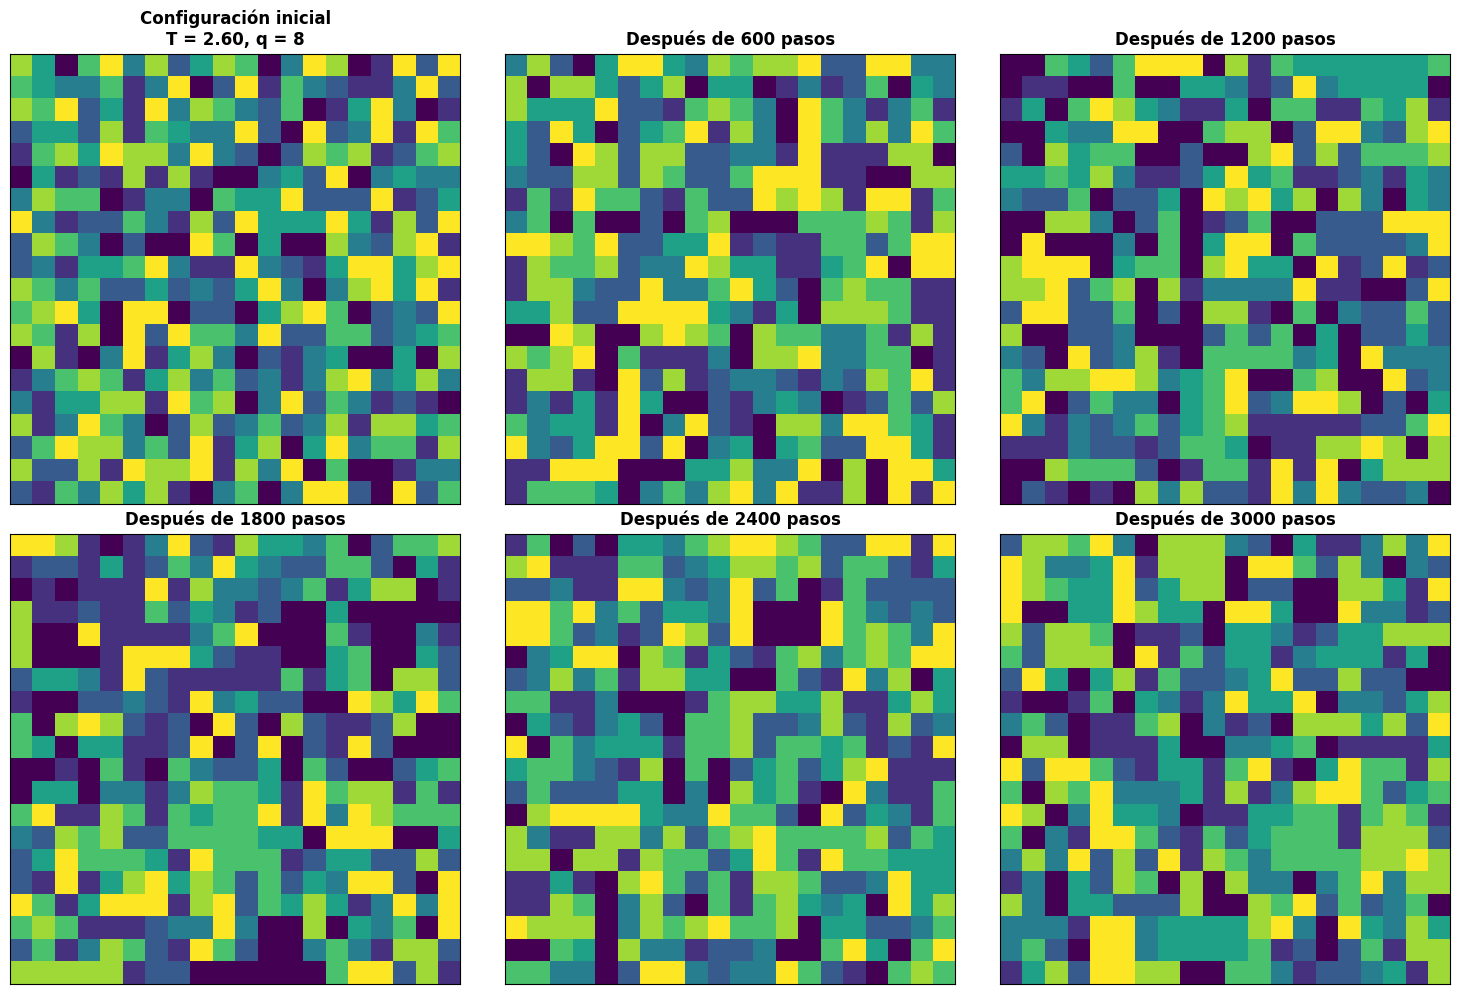

In [ ]:
visualizar_metropolis_potts(T=2.6, L=20, q=8, nSteps=3000)

In [6]:
def histogramas_cerca_transicion(q, L=20):
    """Toma histogramas cerca de la temperatura crítica"""

    # Temperaturas alrededor de T_c
    T_values = [1.0,1.5,2.5]

    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    for idx, T in enumerate(T_values):
        model = PottsModel(L=L, q=q, T=T)
        mc = MonteCarlo(model)
        # Muchos pasos para buen muestreo
        mc.run(steps=20000, thermalization=10000)
        results = Analysis(mc)

        # Histograma de energía por spin
        axes[0, idx].hist(np.array(mc.energy_history)/(L**2), bins=30, alpha=0.7)
        axes[0, idx].set_title(f'q={q}, T={T:.3f}')
        axes[0, idx].set_xlabel('Energía por spin')
        axes[0, idx].set_ylabel('Frecuencia')

        # Histograma de magnetización
        axes[1, idx].hist(mc.mag_history, bins=30, alpha=0.7)
        axes[1, idx].set_xlabel('Magnetización')
        axes[1, idx].set_ylabel('Frecuencia')

    plt.tight_layout()
    plt.savefig("Histogramas_Ising.png")
    plt.show()

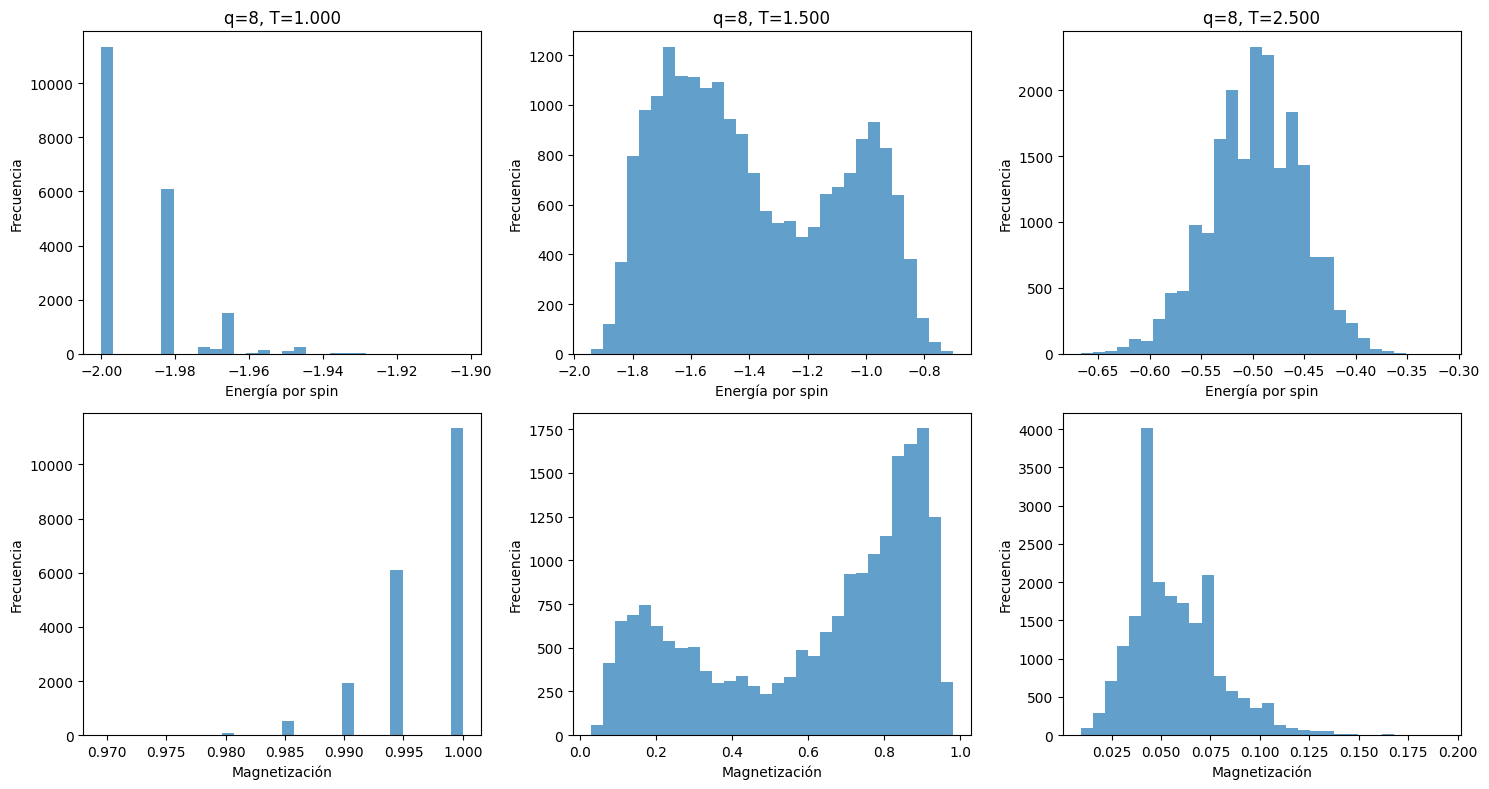

In [7]:
lol = histogramas_cerca_transicion(q=8, L = 15)